In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [2]:
def get_data(start_date, end_date, tickers):
    """
    Fetches the close prices for the specified tickers and calculates the required returns.
    
    Parameters:
    - start_date: The start date for fetching data.
    - end_date: The end date for fetching data.
    - tickers: A list of ticker symbols to download.
    
    Returns:
    - data_df: A DataFrame with close prices and calculated returns.
    """

    # Fetch the data
    data_df = yf.download(tickers, start=start_date, end=end_date, interval="1d")

    # Extract only the Close prices and rename them
    data_df = data_df['Close'][['^GSPC', 'VGSH', 'UPRO', 'SPY']]
    data_df.columns = ['S&P 500 Close', 'VGSH Close', 'UPRO Close', 'SPY Close']

    # Calculate the daily returns. UPRO approximates 2.83x S&P return
    data_df['S&P Returns'] = data_df['S&P 500 Close'].pct_change()
    data_df['Theoretical UPRO Returns'] = data_df['S&P Returns'] * 2.83

    # Calculate the UPRO, VGSH, and SPY returns
    data_df['Actual UPRO Returns'] = data_df['UPRO Close'].pct_change()
    vgsh_daily_return = 0.00434 / 100  # Convert to decimal
    data_df['Theoretical VGSH Returns'] = vgsh_daily_return
    data_df['Actual VGSH Returns'] = data_df['VGSH Close'].pct_change()
    data_df['SPY Returns'] = data_df['SPY Close'].pct_change()

    # Reorder the columns as specified
    data_df = data_df[['S&P 500 Close', 'VGSH Close', 'UPRO Close', 'SPY Close', 'S&P Returns', 'Theoretical UPRO Returns', 
                'Actual UPRO Returns', 'Theoretical VGSH Returns', 'Actual VGSH Returns', 'SPY Returns']]

    # Create the consolidated returns for UPRO and VGSH
    data_df['Consol UPRO Returns'] = data_df['Theoretical UPRO Returns'].where(data_df.index <= '2009-06-25', data_df['Actual UPRO Returns'])
    data_df['Consol VGSH Returns'] = data_df['Theoretical VGSH Returns'].where(data_df.index <= '2009-11-23', data_df['Actual VGSH Returns'])

    return data_df


def calculate_vol_managed_with_filter_strategy(data_df, lookback_period, risk_off=0.2, risk_on=0.2, initial_value=100.0, ema_period=200):
    """
    Calculates a volatility-managed strategy with an additional filter based on the S&P 500's EMA.
    
    When the S&P 500 is above its EMA (default: 200-day EMA), the strategy applies the
    volatility-managed logic (switching between UPRO and VGSH based on volatility thresholds).
    When the S&P 500 is below its EMA, the strategy forces a hold of VGSH.
    
    Parameters:
    - data_df: DataFrame containing S&P 500, UPRO, VGSH prices, and their respective returns.
    - lookback_period: Lookback period for calculating the rolling S&P 500 volatility.
    - risk_off: Volatility threshold (when holding UPRO) at which to switch to VGSH.
    - risk_on: Volatility threshold (when holding VGSH) at which to switch back to UPRO.
    - initial_value: Starting value of the investment.
    - ema_period: Number of days for the EMA calculation of the S&P 500 (default is 200).
    
    Returns:
    - strategy_data: DataFrame with the following columns:
          'Vol-Managed_with_filter Status' (holds either 'UPRO' or 'VGSH'),
          'Vol-Managed_with_filter Value', and
          'Vol-Managed_with_filter Returns'
    """
    data = data_df.copy()
    
    # Calculate daily returns and S&P 500 volatility as before
    data['S&P-Daily-Returns'] = data['S&P Returns']
    data['VGSH-Daily-Returns'] = data['Consol VGSH Returns']
    data['UPRO-Daily-Returns'] = data['Consol UPRO Returns']
    data['S&P-Volatility'] = data['S&P-Daily-Returns'].rolling(window=lookback_period).std() * np.sqrt(252)
    
    # Calculate the EMA for S&P 500 Close using the specified period
    ema_column = f'S&P-{ema_period}EMA'
    data[ema_column] = data['S&P 500 Close'].ewm(span=ema_period, adjust=False).mean()
    
    # Initialize the strategy DataFrame.
    strategy_data = pd.DataFrame(index=data.index)
    # Set initial status based on the first day's S&P 500 close relative to its EMA.
    initial_status = 'UPRO' if data.iloc[0]['S&P 500 Close'] > data.iloc[0][ema_column] else 'VGSH'
    strategy_data['Vol-Managed_with_filter Status'] = initial_status
    strategy_data['Vol-Managed_with_filter Value'] = initial_value
    
    # Iterate over the data (starting from day 1) to update strategy status and value.
    for i in range(1, len(strategy_data)):
        previous_status = strategy_data.iloc[i-1]['Vol-Managed_with_filter Status']
        # Check the filter: use previous day's S&P 500 close vs. its EMA
        if data.iloc[i-1]['S&P 500 Close'] > data.iloc[i-1][ema_column]:
            # When above EMA, apply the volatility-managed logic.
            current_volatility = data.iloc[i-1]['S&P-Volatility']
            if previous_status == 'UPRO' and current_volatility >= risk_off:
                new_status = 'VGSH'
            elif previous_status == 'VGSH' and current_volatility <= risk_on:
                new_status = 'UPRO'
            else:
                new_status = previous_status
        else:
            # When below EMA, force the strategy to hold VGSH.
            new_status = 'VGSH'
        
        # Update the status for the current day.
        strategy_data.iloc[i, strategy_data.columns.get_loc('Vol-Managed_with_filter Status')] = new_status
        
        # Apply a switching fee if the status changes.
        if new_status != previous_status:
            fee = strategy_data.iloc[i-1]['Vol-Managed_with_filter Value'] * 0.002
            new_value = strategy_data.iloc[i-1]['Vol-Managed_with_filter Value'] - fee
        else:
            new_value = strategy_data.iloc[i-1]['Vol-Managed_with_filter Value']
        
        # Update the value based on the asset's return:
        # If the status is 'UPRO', use UPRO's daily returns; otherwise, use VGSH's daily returns.
        if new_status == 'UPRO':
            new_value *= (1 + data.iloc[i]['UPRO-Daily-Returns'])
        else:
            new_value *= (1 + data.iloc[i]['VGSH-Daily-Returns'])
        
        strategy_data.iloc[i, strategy_data.columns.get_loc('Vol-Managed_with_filter Value')] = new_value
    
    # Calculate daily returns for the strategy.
    strategy_data['Vol-Managed_with_filter Returns'] = strategy_data['Vol-Managed_with_filter Value'].pct_change()
    
    return strategy_data


def calculate_vol_managed_strategy(data_df, lookback_period, risk_off=0.2, risk_on=0.2, initial_value=100.0):
    data = data_df.copy()

    # Calculate the daily returns and volatility
    data['S&P-Daily-Returns'] = data['S&P Returns']
    data['VGSH-Daily-Returns'] = data['Consol VGSH Returns']
    data['UPRO-Daily-Returns'] = data['Consol UPRO Returns']
    data['S&P-Volatility'] = data['S&P-Daily-Returns'].rolling(window=lookback_period).std() * np.sqrt(252)

    # Initialize strategy status and value columns
    strategy_data = pd.DataFrame(index=data.index)
    strategy_data['Vol-Managed Status'] = 'UPRO'  # Start with UPRO
    strategy_data['Vol-Managed Value'] = initial_value

    # Iterate over the dataframe to apply the strategy logic
    for i in range(1, len(strategy_data)):
        current_volatility = data.loc[data.index[i-1], 'S&P-Volatility']
        previous_strategy = strategy_data.loc[strategy_data.index[i-1], 'Vol-Managed Status']

        if previous_strategy == 'UPRO' and current_volatility >= risk_off:
            strategy_data.loc[strategy_data.index[i], 'Vol-Managed Status'] = 'VGSH'
        elif previous_strategy == 'VGSH' and current_volatility <= risk_on:
            strategy_data.loc[strategy_data.index[i], 'Vol-Managed Status'] = 'UPRO'
        else:
           strategy_data.loc[strategy_data.index[i], 'Vol-Managed Status'] = previous_strategy

        current_strategy = strategy_data.loc[strategy_data.index[i], 'Vol-Managed Status']

        # Update value based on returns and transaction fees
        if current_strategy != previous_strategy:
            fee = strategy_data.loc[strategy_data.index[i-1], 'Vol-Managed Value'] * 0.002
            strategy_data.loc[strategy_data.index[i], 'Vol-Managed Value'] = strategy_data.loc[strategy_data.index[i-1], 'Vol-Managed Value'] - fee
        else:
            strategy_data.loc[strategy_data.index[i], 'Vol-Managed Value'] = strategy_data.loc[strategy_data.index[i-1], 'Vol-Managed Value']

        if current_strategy == 'UPRO':
            strategy_data.loc[strategy_data.index[i], 'Vol-Managed Value'] *= (1 + data.loc[data.index[i], 'UPRO-Daily-Returns'])
        else:
            strategy_data.loc[strategy_data.index[i], 'Vol-Managed Value'] *= (1 + data.loc[data.index[i], 'VGSH-Daily-Returns'])

    # Calculate daily returns for the strategy
    strategy_data['Vol-Managed Returns'] = strategy_data['Vol-Managed Value'].pct_change()

    return strategy_data


def calculate_snp_buy_and_hold_strategy(data_df, initial_value=100.0):
    data = data_df.copy()

    # Initialize a DataFrame for the strategy
    strategy_data = pd.DataFrame(index=data.index)
    strategy_data['S&P Buy and Hold'] = initial_value

    # Calculate the value of the strategy over time
    for i in range(1, len(strategy_data)):
        strategy_data.loc[strategy_data.index[i], 'S&P Buy and Hold'] = strategy_data.loc[strategy_data.index[i-1], 'S&P Buy and Hold'] * (1 + data.loc[data.index[i], 'S&P Returns'])

    # Calculate daily returns for the strategy
    strategy_data['S&P Returns'] = strategy_data['S&P Buy and Hold'].pct_change()

    return strategy_data


def calculate_upro_buy_and_hold_strategy(data_df, initial_value=100.0):
    data = data_df.copy()

    # Initialize a DataFrame for the strategy
    strategy_data = pd.DataFrame(index=data.index)
    strategy_data['UPRO Buy and Hold'] = initial_value

    # Calculate the value of the strategy over time
    for i in range(1, len(strategy_data)):
        strategy_data.loc[strategy_data.index[i], 'UPRO Buy and Hold'] = strategy_data.loc[strategy_data.index[i-1], 'UPRO Buy and Hold'] * (1 + data.loc[data.index[i], 'Consol UPRO Returns'])

    # Calculate daily returns for the strategy
    strategy_data['UPRO Returns'] = strategy_data['UPRO Buy and Hold'].pct_change()

    return strategy_data


def calculate_rotation_strategy(data_df, upro_ath=1.88, sp500_ath=1104, risk_on_percentage=19):
    """
    Calculate the rotation strategy based on the UPRO and S&P 500 ATHs and the risk_on_percentage.
    
    Parameters:
    - data_df: pandas DataFrame containing the UPRO and S&P 500 data.
    - upro_ath: Starting all-time high of UPRO. Default is 2.17.
    - sp500_ath: Starting all-time high of the S&P 500. Default is 1565.15.
    - risk_on_percentage: Percentage drop from the S&P 500 ATH at which to switch back to UPRO. Default is 0.2%.
    
    Returns:
    - strategy_df: DataFrame with the calculated strategy values, returns, and statuses.
    """

    # Initialize columns for the strategy DataFrame
    strategy_df = pd.DataFrame(index=data_df.index)
    strategy_df['Rotation Strategy Value'] = 100.0  # Starting value
    strategy_df['Rotation Status'] = 'UPRO'  # Initial status
    strategy_df['Rotation Returns'] = 0.0

    # Track the all-time highs for S&P 500 and UPRO dynamically
    dynamic_sp500_ath = sp500_ath
    dynamic_upro_ath = upro_ath

    for i in range(1, len(strategy_df)):
        previous_status = strategy_df.iloc[i-1]['Rotation Status']
        current_upro_value = data_df.iloc[i]['UPRO Close']
        current_sp500_value = data_df.iloc[i]['S&P 500 Close']

        # Update the dynamic S&P 500 ATH
        dynamic_sp500_ath = max(dynamic_sp500_ath, current_sp500_value)

        # Update the dynamic UPRO ATH
        dynamic_upro_ath = max(dynamic_upro_ath, current_upro_value)

        # Calculate the dynamic risk-on level based on the updated S&P 500 ATH
        risk_on_level = dynamic_sp500_ath * (1 - risk_on_percentage / 100)

        # If in UPRO and it reaches or exceeds its ATH, switch to SPY
        if current_upro_value >= dynamic_upro_ath:
            strategy_df.iloc[i:, strategy_df.columns.get_loc('Rotation Status')] = 'SPY'
        
        # If in SPY and the S&P 500 drops below the dynamic risk-on level, switch to UPRO
        elif previous_status == 'SPY' and current_sp500_value <= risk_on_level:
            strategy_df.iloc[i:, strategy_df.columns.get_loc('Rotation Status')] = 'UPRO'

        # Update the strategy value based on the current status
        current_status = strategy_df.iloc[i]['Rotation Status']
        if current_status == 'UPRO':
            strategy_df.iloc[i, strategy_df.columns.get_loc('Rotation Strategy Value')] = \
                strategy_df.iloc[i-1]['Rotation Strategy Value'] * (1 + data_df.iloc[i]['Consol UPRO Returns'])
        else:  # current_status == 'SPY'
            strategy_df.iloc[i, strategy_df.columns.get_loc('Rotation Strategy Value')] = \
                strategy_df.iloc[i-1]['Rotation Strategy Value'] * (1 + data_df.iloc[i]['SPY Returns'])

        # Calculate the returns for the current day
        strategy_df.iloc[i, strategy_df.columns.get_loc('Rotation Returns')] = \
            strategy_df.iloc[i]['Rotation Strategy Value'] / strategy_df.iloc[i-1]['Rotation Strategy Value'] - 1

    # Keep only the desired columns
    strategy_df = strategy_df[['Rotation Strategy Value', 'Rotation Status', 'Rotation Returns']]

    return strategy_df


def calculate_investment_metrics(combined_df, strategy_names, risk_free_rate=0.0):
    """
    Calculates performance metrics for each investment strategy.
    
    Updated to include the new 'Vol-Managed_with_filter' strategy.
    
    Parameters:
    - combined_df: DataFrame that contains the strategy values and returns.
    - strategy_names: List of strategy value column names (e.g., 'Vol-Managed Value', 
                      'Vol-Managed_with_filter Value', etc.).
    - risk_free_rate: The risk-free rate used for Sharpe and Sortino ratios.
    
    Returns:
    - metrics_df: DataFrame containing performance metrics for each strategy.
    """
    metrics = {}
    
    # Map each strategy name to its corresponding returns column.
    return_columns = {
        'Vol-Managed Value': 'Vol-Managed Returns',
        'Vol-Managed_with_filter Value': 'Vol-Managed_with_filter Returns',
        'Rotation Strategy Value': 'Rotation Returns',
        'S&P Buy and Hold': 'S&P Returns',
        'UPRO Buy and Hold': 'UPRO Returns'
    }
    
    for strategy in strategy_names:
        returns_column_name = return_columns.get(strategy)
        cumulative_column_name = strategy
        
        returns = combined_df[returns_column_name].dropna()
        cumulative_values = combined_df[cumulative_column_name]
    
        # Calculate annualized return and standard deviation.
        avg_daily_return = returns.mean()
        annualized_return = avg_daily_return * 252
        std_dev = returns.std() * np.sqrt(252)
    
        # Calculate Sharpe Ratio.
        sharpe_ratio = (annualized_return - risk_free_rate) / std_dev if std_dev != 0 else np.nan
    
        # Calculate downside deviation for the Sortino ratio.
        downside_returns = returns[returns < risk_free_rate]
        downside_std_dev = downside_returns.std() * np.sqrt(252)
        sortino_ratio = (annualized_return - risk_free_rate) / downside_std_dev if downside_std_dev != 0 else np.nan
    
        # Calculate cumulative return and maximum drawdown.
        cumulative_return = (1 + returns).cumprod()
        rolling_max = cumulative_return.cummax()
        drawdown = cumulative_return / rolling_max - 1
        max_drawdown = drawdown.min()
    
        # Calculate CAGR.
        cagr = (cumulative_values.iloc[-1] / cumulative_values.iloc[0]) ** (
            1 / ((cumulative_values.index[-1] - cumulative_values.index[0]).days / 365.25)) - 1
    
        # Calculate Calmar Ratio.
        calmar_ratio = cagr / abs(max_drawdown) if max_drawdown != 0 else np.nan
    
        # Calculate Omega Ratio.
        omega_numer = returns[returns > risk_free_rate].sum()
        omega_denom = abs(returns[returns < risk_free_rate].sum())
        omega_ratio = omega_numer / omega_denom if omega_denom != 0 else np.nan
    
        # Percentage of profitable days.
        profitable_days = (returns > 0).mean() * 100
    
        # Skewness and kurtosis.
        skewness = stats.skew(returns)
        kurtosis = stats.kurtosis(returns)
    
        # For volatility-managed strategies, also calculate trade counts and state durations.
        if strategy in ['Vol-Managed Value', 'Vol-Managed_with_filter Value']:
            if strategy == 'Vol-Managed Value':
                status_column = combined_df['Vol-Managed Status']
                mapping = {'UPRO': 1, 'VGSH': 0, 'SPY': 2}
            else:
                status_column = combined_df['Vol-Managed_with_filter Status']
                mapping = {'UPRO': 1, 'VGSH': 0}
            strategy_numeric = status_column.map(mapping)
            trades = strategy_numeric.diff().abs().sum()
    
            state_durations = strategy_numeric.groupby((strategy_numeric != strategy_numeric.shift()).cumsum()).transform('size')
            avg_days_upro = state_durations[strategy_numeric == mapping.get('UPRO')].mean()
            avg_days_vgsh = state_durations[strategy_numeric == mapping.get('VGSH')].mean()
            avg_days_spy = (state_durations[strategy_numeric == mapping.get('SPY')].mean() 
                            if 2 in mapping.values() else np.nan)
        else:
            trades = np.nan
            avg_days_upro = np.nan
            avg_days_vgsh = np.nan
            avg_days_spy = np.nan
    
        metrics[strategy] = {
            'CAGR': round(cagr * 100, 3),  # in percentage
            'Sharpe Ratio': round(sharpe_ratio, 3),
            'Sortino Ratio': round(sortino_ratio, 3) if not np.isnan(sortino_ratio) else None,
            'Standard Deviation': round(std_dev * 100, 3),  # in percentage
            'Downside Deviation': round(downside_std_dev * 100, 3),  # in percentage
            'Maximum Drawdown': round(max_drawdown * 100, 3),  # in percentage
            'Calmar Ratio': round(calmar_ratio * 100, 3) if not np.isnan(calmar_ratio) else None,
            'Omega Ratio': round(omega_ratio * 100, 3) if not np.isnan(omega_ratio) else None,
            '% Profitable Days': round(profitable_days, 3),
            'Skewness': round(skewness, 3),
            'Kurtosis': round(kurtosis, 3),
            'Number of Trades': int(trades) if pd.notna(trades) else None,
            'Avg Days in UPRO': round(avg_days_upro, 3) if pd.notna(avg_days_upro) else None,
            'Avg Days in VGSH': round(avg_days_vgsh, 3) if pd.notna(avg_days_vgsh) else None,
            'Avg Days in SPY': round(avg_days_spy, 3) if pd.notna(avg_days_spy) else None
        }
    
    metrics_df = pd.DataFrame(metrics)
    return metrics_df


def plot_investment_values_and_volatility(combined_df, data_df, strategy_names, lookback_period):
    """
    Plots the change in investment value over time for multiple strategies and the S&P 500 volatility.
    
    Updated so that if you include the new 'Vol-Managed_with_filter Value' strategy in strategy_names,
    it will be plotted alongside the other strategies.
    
    Parameters:
    - combined_df: DataFrame containing the investment strategy values.
    - data_df: DataFrame containing the S&P 500 returns data.
    - strategy_names: List of column names corresponding to the strategy values.
    - lookback_period: Lookback period used for calculating the S&P 500 volatility.
    """
    # Calculate the rolling volatility of the S&P 500.
    data_df[f'{lookback_period}-Day Volatility'] = data_df['S&P Returns'].rolling(window=lookback_period).std() * np.sqrt(252)
    
    # Create a figure with two subplots.
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18, 10))
    
    # First subplot: Plot the change in investment value for each strategy.
    for strategy in strategy_names:
        axs[0].plot(combined_df.index, combined_df[strategy], label=strategy)
    axs[0].set_title('Change in Investment Value Over Time')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Investment Value ($)')
    axs[0].legend()
    axs[0].grid(True)
    
    # Second subplot: Plot the S&P 500 volatility.
    axs[1].plot(data_df.index, data_df[f'{lookback_period}-Day Volatility'], label=f'{lookback_period}-Day S&P Volatility', color='red')
    axs[1].set_title(f'{lookback_period}-Day S&P Volatility Over Time')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel(f'{lookback_period}-Day Volatility')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()


def plot_returns_distribution(returns, bins=50, title="Distribution of Returns"):
    """
    Plots the distribution of returns for a given strategy.
    
    This function is generic and works for any returns Series, including the new
    'Vol-Managed_with_filter Returns'.
    
    Parameters:
    - returns: A pandas Series (or convertible to one) of returns.
    - bins: Number of bins for the histogram.
    - title: Title for the plot.
    """
    # Convert returns to a pandas Series if needed.
    if not isinstance(returns, pd.Series):
        returns = pd.Series(returns)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(returns, bins=bins, kde=True, color='blue')
    plt.xlabel("Returns")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.grid(True)
    plt.show()

In [ ]:
# Start and end dates
start_date = '2000-01-01'
# end_date = '2020-01-01'
# start_date = '2020-01-01'
end_date = '2010-03-10'

# Fetch historical data for the S&P 500, VGSH, and UPRO
tickers = ['^GSPC', 'VGSH', 'UPRO', 'SPY']
data_df = get_data(start_date, end_date, tickers)

# Define lookback period and volatility upper threshold
lookback_period = 25
risk_off = 0.3
risk_on = 0.25

# Calculate each strategy
vol_managed_with_filter_df = calculate_vol_managed_with_filter_strategy(data_df, lookback_period, risk_off, risk_on, initial_value=100.0, ema_period=200)
vol_managed_df = calculate_vol_managed_strategy(data_df, lookback_period, risk_off, risk_on)
snp_buy_and_hold_df = calculate_snp_buy_and_hold_strategy(data_df)
upro_buy_and_hold_df = calculate_upro_buy_and_hold_strategy(data_df)
rotation_strategy = calculate_rotation_strategy(data_df, upro_ath=1.88, sp500_ath=1104, risk_on_percentage=19)

# Concatenate all strategy data
combined_df = pd.concat([vol_managed_with_filter_df, vol_managed_df, snp_buy_and_hold_df, upro_buy_and_hold_df, rotation_strategy], axis=1)

# Add the closing prices of S&P 500, VGSH, UPRO, and SPY to the combined_df
combined_df['S&P 500 Close'] = data_df['S&P 500 Close']
combined_df['VGSH Close'] = data_df['VGSH Close']
combined_df['UPRO Close'] = data_df['UPRO Close']
combined_df['SPY Close'] = data_df['SPY Close']
combined_df[f'{lookback_period}-Day S&P-Volatility'] = combined_df['S&P Returns'].rolling(window=lookback_period).std() * np.sqrt(252)

# Display the last few rows of the combined dataframe
combined_df.tail()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


In [ ]:
strategy_names = ['Vol-Managed_with_filter Value', 'Vol-Managed Value', 'Rotation Strategy Value', 'S&P Buy and Hold', 'UPRO Buy and Hold']
metrics_df = calculate_investment_metrics(combined_df, strategy_names)
metrics_df

,Vol-Managed_with_filter Value,Vol-Managed Value,Rotation Strategy Value,S&P Buy and Hold,UPRO Buy and Hold
CAGR,4.648,-10.066,-18.958,-2.366,-17.269
Sharpe Ratio,0.307,-0.003,-0.021,0.002,0.013
Sortino Ratio,0.301,-0.004,-0.028,0.003,0.017
Standard Deviation,25.661,45.700,62.673,22.139,62.757
Downside Deviation,26.140,35.075,47.012,16.576,47.012
Maximum Drawdown,-47.724,-92.361,-96.779,-56.775,-96.779
Calmar Ratio,9.740,-10.899,-19.589,-4.167,-17.844
Omega Ratio,107.363,99.939,99.608,100.042,100.238
% Profitable Days,75.420,58.968,52.383,52.403,52.403
Skewness,-0.573,-0.096,0.094,0.093,0.089


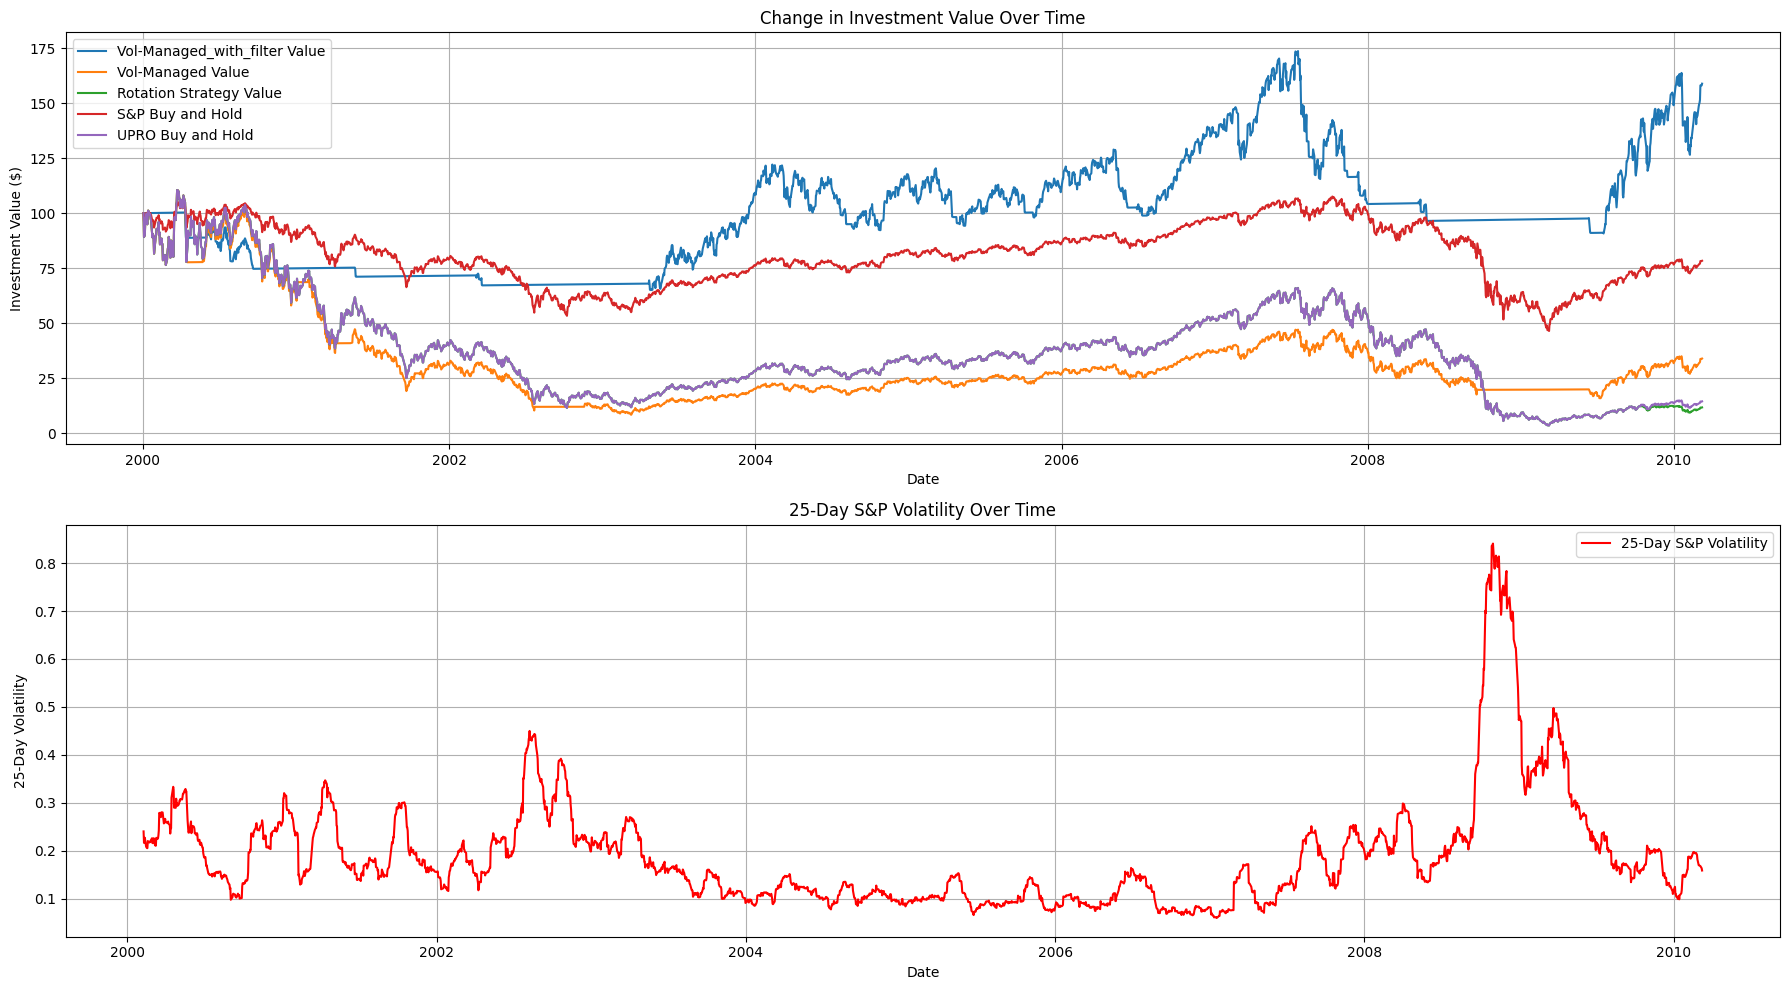

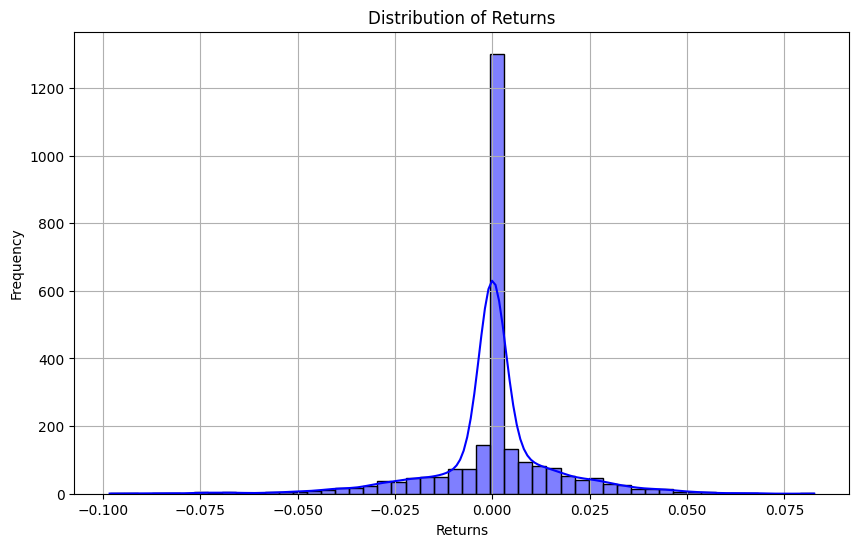

In [ ]:
# Example usage:
strategy_names = ['Vol-Managed_with_filter Value', 'Vol-Managed Value', 'Rotation Strategy Value', 'S&P Buy and Hold', 'UPRO Buy and Hold']
plot_investment_values_and_volatility(combined_df, data_df, strategy_names, lookback_period)
# plot_returns_distribution(combined_df["Vol-Managed Returns"])
plot_returns_distribution(combined_df["Vol-Managed_with_filter Returns"])